В цій практичній роботі ми спробуємо реалізувати нейронну мережу з двох шарів (прихований і вихідний). Запропонований підхід стане заготовкою для реалізації наступних оптимізацій: MBGD, ADAM та регуляризації. 

Сьогодні ж вам пропонується додати до цього класу підтримку довільної кількості шарів та нейронів в них (наприклад, передавати їх параметром в конструктор, як це робиться в MLPClassifier за допомогою hidden_layer_sizes). Також потрібно передбачити можливість ранньої зупинки ітераційного процесу, якщо значення штрафної функції не покращуватиметься протягом певної кількості ітерацій. Наприклад, якщо протягом $k$ ітерацій штрафна функція за модулем не стане меншою, ніж на поточному кроці.

In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score

import sklearn.linear_model

In [11]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [12]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=cm_bright)

In [164]:
class NeuralNet:
    """
    NN for binary classification
    Attributes:
    ...
    """
    
    def __init__(self, normalize = True, learning_rate = 0.01, max_iter = 30000, hidden_layer_sizes=(100,), epsilon=1e-6):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.normalize = normalize
        self.hidden_layer_sizes = hidden_layer_sizes
        self.n_layers = 1 + len(hidden_layer_sizes)
        self.epsilon = epsilon
    
    def __normalize(self, X, mean = None, std = None):
        """
        Зверніть увагу, що нормалізація вхідних даних є дуже важливою для швидкодії нейронних мереж.
        """
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s**2
        return X_new, m, s

    def __sigmoid(self, Z):
        """
        В наступних практичних потрібно буде додати підтримку й інших активаційних функцій - це один з гіперпараметрів. 
        Їх можна вибирати для всіх шарів одночасно або мати різні активаційні функції на кожному з них.
        """
        return 1 / (1 + np.exp(-Z))
    
    def __initialize_parameters(self, n_x, hidden_layers):
        W = list()
        b = list()
        
        h = list(hidden_layers)
        h.insert(0, n_x)
        h.append(1)
        hidden_layers = tuple(h)
        
        for i in range(1, self.n_layers+1):
            W.append(np.random.randn(hidden_layers[i], hidden_layers[i-1]) * 0.01)
            b.append(np.zeros((hidden_layers[i], 1)))

        self.parameters = {"W" : W, "b" : b}
       
    def __forward_propagation(self, X):
        W = self.parameters["W"]
        b = self.parameters["b"]

        A = list()
        Z = list()
        
        for i in range(0, self.n_layers):
            if i == 0:
                Z.append(np.dot(W[i], X) + b[i])
            else:
                Z.append(np.dot(W[i], A[i-1]) + b[i])
            A.append(self.__sigmoid(Z[i]))
                       
        cache = (W, b, Z, A)

        return A[-1], cache
    
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        return J
        
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        n = X.shape[0]
        (W, b, Z, A) = cache
        
        dW = [None] * (self.n_layers)
        dA = [None] * (self.n_layers)
        dZ = [None] * (self.n_layers)
        db = [None] * (self.n_layers)
        
        dZ[-1] = (A[-1] - Y)
        dW[-1] = (1. / m * np.dot(dZ[-1], A[-2].T))
        db[-1] = (1. / m * np.sum(dZ[-1], axis = 1, keepdims = True))
        
        for i in range(self.n_layers-1, 0, -1):
            dA[i-1] = np.dot(W[i].T, dZ[i])
            dZ[i-1] = np.multiply(dA[i-1], np.multiply(A[i-1], 1 - A[i-1]))
            if i-1 == 0:
                dW[i-1] = 1. / m * np.dot(dZ[i-1], X.T)
            else:
                dW[i-1] = 1. / m * np.dot(dZ[i-1], A[i-2].T)
            db[i-1] = 1. / m * np.sum(dZ[i-1], axis = 1, keepdims = True)        
        
        grads = {"dZ" : dZ, "dW" : dW, "db" : db}
        return grads
    
    def __update_parameters(self, grads):
        W = self.parameters["W"]
        b = self.parameters["b"]

        dW = grads["dW"]
        db = grads["db"]
        
        for i in range(self.n_layers):
            W[i] = W[i] - self.learning_rate * dW[i]
            b[i] = b[i] - self.learning_rate * db[i]

    def fit(self, X_vert, Y_vert, print_cost = True):
        self.n_iter = 0
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        cost_history = []
        
        m = X.shape[1]
        n_x = X.shape[0]
        
        self.__initialize_parameters(n_x, self.hidden_layer_sizes)

        for i in range(self.max_iter):
            self.n_iter = i
            A, cache = self.__forward_propagation(X)

            cost = self.compute_cost(A, Y)

            grads = self.__backward_propagation(X, Y, cache)

            self.__update_parameters(grads)
            
            cost_history.append(cost)
            
            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 1000 == 0:
                costs.append(cost)
                
            if i > 1 and cost < 0.5 and abs(cost-cost_history[-2]) < self.epsilon:
                break

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        
        return np.column_stack((probs.T, 1 - probs.T))
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)[:, 0]
        return (positive_probs >= 0.5).astype(int)   


Спочатку спробуйте цей клас на одній задачі, а потім на іншій.

In [14]:
#data_columns = ["exam1", "exam2"]
#target_column = "submitted"
#df = pd.read_csv("sats.csv")
#X, y = df[data_columns].values, df[target_column].reshape((df.shape[0], 1))
#print('Training set: X={}, y={}'.format(X.shape, y.shape))

In [15]:
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("tests.csv")
X, y = df[data_columns].values, df[target_column]
print('Training set: X={}, y={}'.format(X.shape, y.shape))

Training set: X=(118, 2), y=(118,)


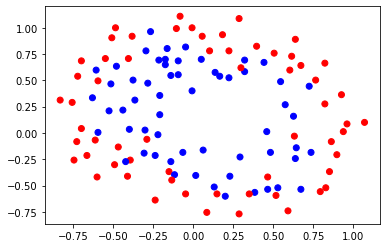

In [17]:
plot_data(X, y)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
print('Training set: X={}, y={}'.format(X_train.shape, y_train.shape))
print('Test set: X={}, y={}'.format(X_test.shape, y_test.shape))

Training set: X=(94, 2), y=(94,)
Test set: X=(24, 2), y=(24,)


In [225]:
cls = NeuralNet(normalize = True, learning_rate = 0.5, max_iter = 1000000, hidden_layer_sizes=(20,10,), epsilon=1e-7)

In [226]:
cls.n_layers

3

0-th iteration: 0.6931013135463351
1000-th iteration: 0.6929207462387434
2000-th iteration: 0.6929206508262388
3000-th iteration: 0.6929205245338185
4000-th iteration: 0.6929203387140147
5000-th iteration: 0.6929200399648461
6000-th iteration: 0.6929195155752363
7000-th iteration: 0.6929184938256696
8000-th iteration: 0.692916197820945
9000-th iteration: 0.6929097831704423
10000-th iteration: 0.6928835702583056
11000-th iteration: 0.6926373255763127
12000-th iteration: 0.6872064019323132
13000-th iteration: 0.648707608856303
14000-th iteration: 0.6010544716467368
15000-th iteration: 0.5364154638037847
16000-th iteration: 0.40605680787614046
17000-th iteration: 0.3288739027199716
18000-th iteration: 0.2821313209960477


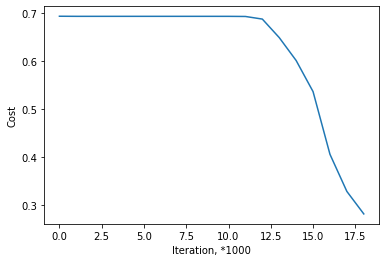

In [227]:
cls.fit(X_train, y_train.values.reshape((X_train.shape[0], 1)))

In [228]:
cls.n_iter

18655

In [229]:
print(cls.parameters)

{'W': [array([[-1.25758243, -0.13859104],
       [ 2.20513716,  0.71108941],
       [ 0.76700171, -0.30288728],
       [-0.56019308, -1.3311814 ],
       [ 0.18589285, -2.7765223 ],
       [ 1.24127621,  0.20091962],
       [-0.10664506, -2.48375849],
       [ 0.97465955,  0.0135482 ],
       [ 1.2349529 ,  0.33379995],
       [ 1.94926255,  0.72357953],
       [ 0.70413948, -0.78923719],
       [-0.6481952 , -0.71296565],
       [-1.19644886, -0.11192142],
       [-2.27077621, -1.71251638],
       [-0.81702722,  0.50885625],
       [ 2.447267  ,  0.78507564],
       [ 0.73217403, -0.38059523],
       [-1.4984732 , -0.22394899],
       [-0.59342787, -1.34844084],
       [ 1.01535136,  0.17237105]]), array([[-1.05866289e-03,  2.83818299e-02,  6.69589716e-03,
        -9.03906921e-02, -9.73417769e-02,  2.58055747e-02,
         1.02361819e-01,  1.49034304e-02,  8.47413973e-03,
         4.78487542e-02,  2.54622586e-02, -1.66180981e-01,
        -4.45302361e-02,  8.64629296e-02,  5.12393693e-

In [230]:
Y_prob = cls.predict_proba(X_test)
print(Y_prob)

[[0.01113827 0.98886173]
 [0.00660718 0.99339282]
 [0.03797221 0.96202779]
 [0.98932807 0.01067193]
 [0.20496239 0.79503761]
 [0.14177519 0.85822481]
 [0.04787633 0.95212367]
 [0.99506487 0.00493513]
 [0.1790414  0.8209586 ]
 [0.87591908 0.12408092]
 [0.83597877 0.16402123]
 [0.82974154 0.17025846]
 [0.21440574 0.78559426]
 [0.99687483 0.00312517]
 [0.0205919  0.9794081 ]
 [0.184105   0.815895  ]
 [0.44131443 0.55868557]
 [0.32651487 0.67348513]
 [0.05625419 0.94374581]
 [0.96293368 0.03706632]
 [0.9753629  0.0246371 ]
 [0.03050732 0.96949268]
 [0.06518768 0.93481232]
 [0.01980785 0.98019215]]


In [231]:
Y_hat = cls.predict(X_test)
Y_hat

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0])

In [232]:
accuracy_score(y_test, Y_hat)

0.8333333333333334

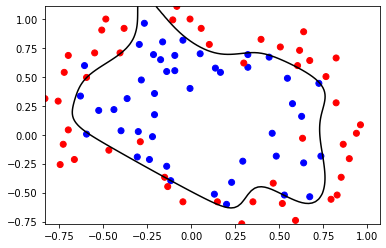

In [233]:
plot_data(X_train, y_train)
plot_surface(cls, X[:, 0], X[:, 1])

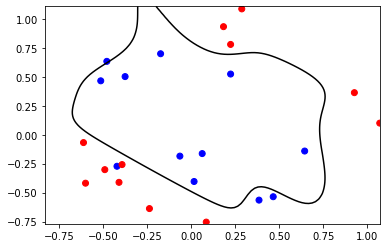

In [234]:
plot_data(X_test, y_test)
plot_surface(cls, X[:, 0], X[:, 1])

Зверніть увагу на границю прийняття рішення. Модель старається побудувати складну криву, що може свідчити про її перетренування. Порівняйте отримані результати з класом з sklearn. Спробуйте додати нові шари для нашого класу та порівняти результати тоді. Поекспериментуйте з гіперпараметрами для обох класів.

In [219]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (20,10,), max_iter = 100000, activation = 'relu', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant', random_state=0)

In [220]:
clf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20, 10), learning_rate='constant',
              learning_rate_init=0.01, max_fun=15000, max_iter=100000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

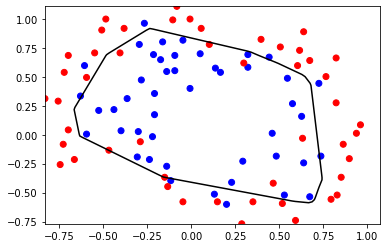

In [221]:
plot_data(X_train, y_train)
plot_surface(clf, X[:, 0], X[:, 1])

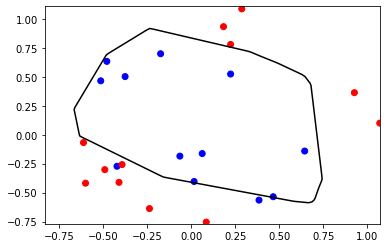

In [222]:
plot_data(X_test, y_test)
plot_surface(clf, X[:, 0], X[:, 1])

In [223]:
accuracy_score(y_test, clf.predict(X_test))

0.9166666666666666

In [224]:
clf.n_iter_

935